<h2>Loading libraries and raw data</h2>

In [18]:
## Basic packages
import numpy as np
import pandas as pd 
import warnings
warnings.filterwarnings('ignore')
import pprint as pp

## xgboost
import xgboost as xgb ## pip install xgboost
from src.xgboost_helpers import * # helper functions

## Ploting 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import graphviz ## pip install graphviz 

## sklearn for model selection 
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn import model_selection

## sklearn logistic regression and random forest classifier 
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

### Load motion data
Load and clean smartphone motion data.
* maybe a small description of data or link
* is it part of this data from UCL datasets? https://archive.ics.uci.edu/ml/datasets/human+activity+recognition+using+smartphones

In [19]:
set_mpl_params()
df = pd.read_csv("data/motion_smartphone.csv")
df.head()

,subject,activity,tbodyacc.mean.x,tbodyacc.mean.y,tbodyacc.mean.z,tgravityacc.mean.x,tgravityacc.mean.y,tgravityacc.mean.z,tbodyaccjerk.mean.x,tbodyaccjerk.mean.y,...,fbodyaccjerk.mean.x,fbodyaccjerk.mean.y,fbodyaccjerk.mean.z,fbodygyro.mean.x,fbodygyro.mean.y,fbodygyro.mean.z,fbodyaccmag.mean,fbodybodyaccjerkmag.mean,fbodybodygyromag.mean,fbodybodygyrojerkmag.mean
0,1,4,0.277331,-0.017384,-0.111148,0.935223,-0.282165,-0.068103,0.074042,0.028272,...,-0.170547,-0.035226,-0.468999,-0.339032,-0.103059,-0.255941,-0.128623,-0.057119,-0.199253,-0.319309
1,1,6,0.255462,-0.023953,-0.097302,0.893351,-0.362153,-0.075403,0.101373,0.019486,...,-0.479875,-0.413445,-0.685474,-0.492612,-0.319475,-0.453597,-0.352396,-0.442652,-0.325961,-0.634665
2,1,5,0.289188,-0.009919,-0.107566,0.931874,-0.266610,-0.062120,0.054155,0.029650,...,-0.027664,-0.128667,-0.288335,-0.352450,-0.055702,-0.031869,0.096585,0.026218,-0.185720,-0.281963
3,1,2,0.261238,-0.001308,-0.104544,0.831510,0.204412,0.332044,0.077483,-0.000619,...,-0.986597,-0.981579,-0.986053,-0.976161,-0.975839,-0.951316,-0.947783,-0.985262,-0.958436,-0.989798
4,1,3,0.278918,-0.016138,-0.110602,0.942952,-0.272984,0.013491,0.075377,0.007976,...,-0.994631,-0.985419,-0.990752,-0.986387,-0.988984,-0.980773,-0.985356,-0.992542,-0.984618,-0.994815


### Processing and summary statistics 

In [20]:
## Remove subject
df = df.drop("subject",axis=1)

## Convert the activity labels from 1-6 to 0-5
df.activity -= 1

## Check the data type of each variable and dimension of the data
display(df.shape)

## Distribution of activities to classify 
df["activity"].value_counts()

(180, 34)

5    30
4    30
3    30
2    30
1    30
0    30
Name: activity, dtype: int64

## An example analysis by xgboost
- split data into test/train
- convert to xgb format -- a DMatrix is an internal structure optimized for memory efficiency and training speed
- train model on test data

In [21]:
## Generate training and testing set, including all predictor variables
InputTrain, InputTest, LabelTrain, LabelTest =\
    train_test_split(df.drop(["activity"], axis = 1),
                     df["activity"], test_size = 0.3,
                     random_state = 5)

## Load the data into xgb data format
dtrain = xgb.DMatrix(InputTrain, label=LabelTrain)
dtest = xgb.DMatrix(InputTest, label=LabelTest)

### Training an xgboost model
The booster parameters control the ensemble of weak learners, eg. decision trees. Multiple metrics can be used in the validation step by
passing a list to 'eval_metric', eg. for classification you could use
both 'auc' (area under ROC curve) and 'merror' (#(wrong cases)/#(all cases)).

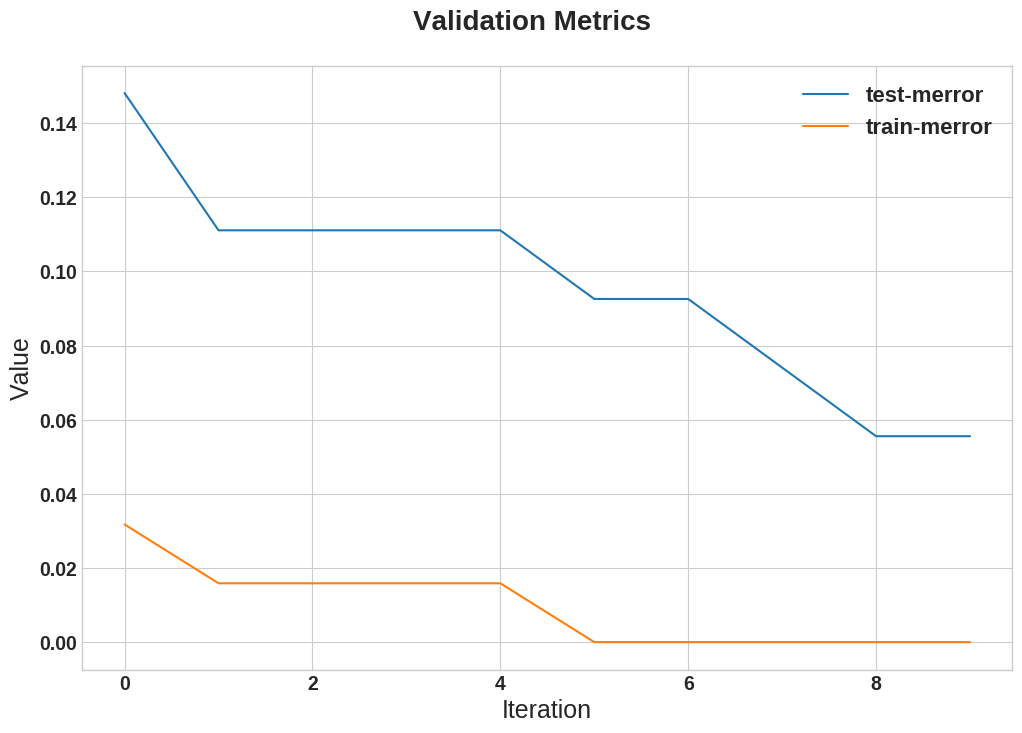

In [22]:
## Booster parameters - control tree building algorithm
# note: some 'eval_metric's are not implemented for multi-class
# classification, eg. 'auc' (area under ROC)
param = {'max_depth': 2,               # max. tree depth
         'eta': 0.5,                   # learning rate
         'silent': 1,                  # 0 to print messages
         'objective': 'multi:softmax', # multi-class softmax
         'num_class': 6,               # num. classes for multi:softmax
         'nthread': 4,                 # threads to use
         'eval_metric': 'merror'       # 'auc' not impl. for multi-class
}

## Validations set to watch performance
evallist = [(dtest, 'test'), (dtrain, 'train')]
evals = dict()                  # store validations at each iteration

# xgboost on a training set
num_round = 10
model = xgb.train(param, dtrain, num_round, evals=evallist,
                  evals_result=evals, verbose_eval=False)
plot_xgb_evals(evals) # merror after each iteration

## Xgboost shows good performance (low error rate)

Confusion Matrix
------------------------
array([[ 6,  0,  0,  0,  0,  0],
       [ 0, 10,  2,  0,  0,  0],
       [ 0,  0,  5,  0,  0,  0],
       [ 0,  0,  0, 12,  0,  1],
       [ 0,  0,  0,  0, 10,  0],
       [ 0,  0,  0,  0,  0,  8]])


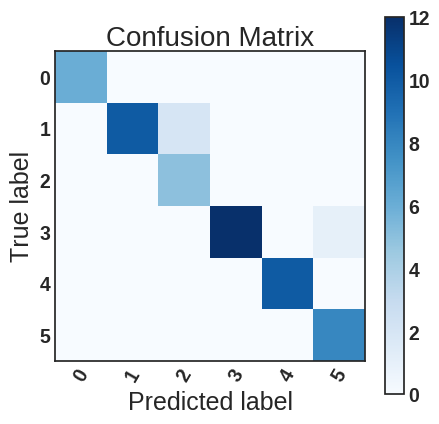


Classification Report
-----------------------


,0,1,2,3,4,5,micro avg,macro avg,weighted avg
f1-score,1.0,0.909091,0.833333,0.960000,1.0,0.941176,0.944444,0.940600,0.946022
precision,1.0,1.000000,0.714286,1.000000,1.0,0.888889,0.944444,0.933862,0.957084
recall,1.0,0.833333,1.000000,0.923077,1.0,1.000000,0.944444,0.959402,0.944444
support,6.0,12.000000,5.000000,13.000000,10.0,8.000000,54.000000,54.000000,54.000000


In [23]:
# Prediction
LabelPred = model.predict(dtest)

# Get model classification statistics
cm, report = xgb_metrics(model, dtest, LabelTest)

# Confusion matrix
set_mpl_params(style='seaborn-white')
print ("Confusion Matrix\n------------------------")
pp.pprint(cm), plot_confusion_matrix(cm, np.unique(LabelTest))

# Classification Report
print("\nClassification Report\n-----------------------")
report

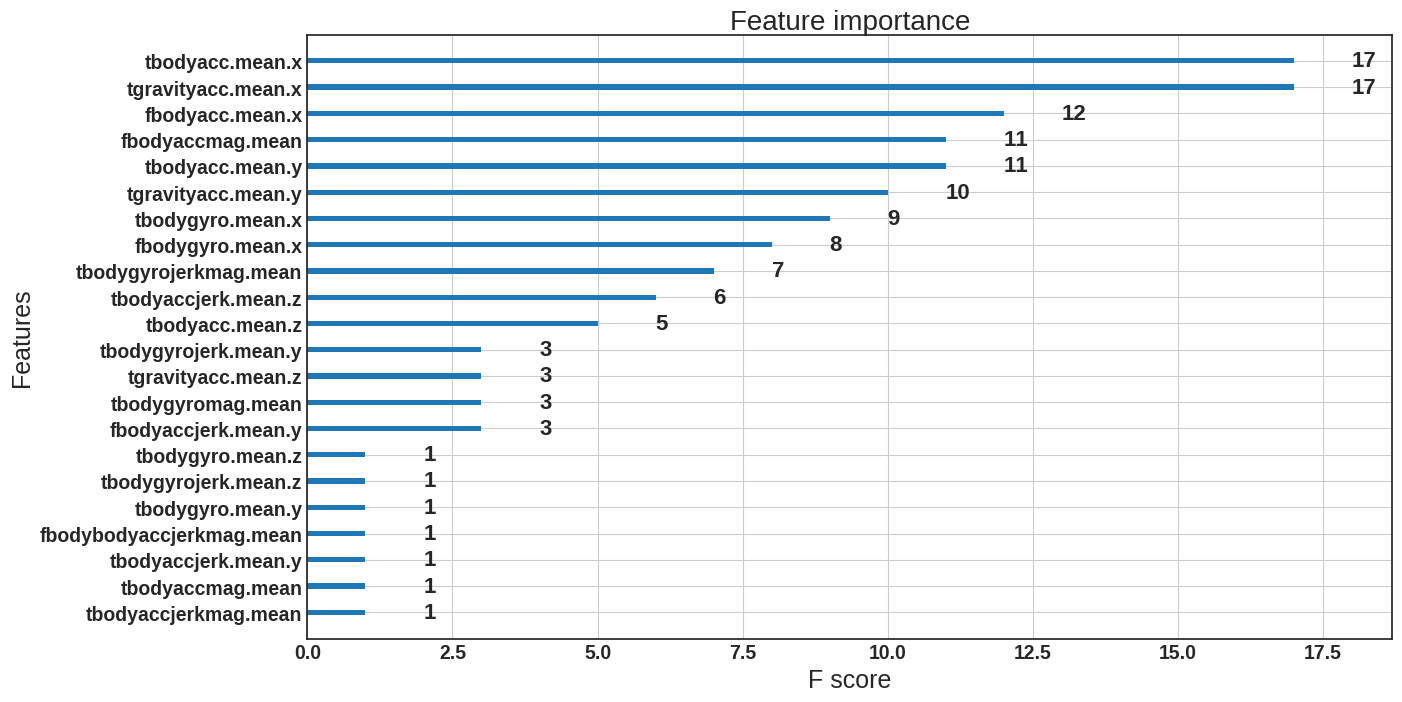

In [24]:
## Variable importance plot
xgb.plot_importance(model)

<b>"tbody acceleration" (x, y and z directions) looks like the most important feature to include in the model</b>

## Cross validation for xgboost
There are multiple options
- XBGoost library has builtin CV support
- can use the XGBoost sklearn interface with sklearn CV functions

In [25]:
## update booster params
param = {**param, **{'max_depth': 3, 'eta': 0.3}}
param

{'max_depth': 3,
 'eta': 0.3,
 'silent': 1,
 'objective': 'multi:softmax',
 'num_class': 6,
 'nthread': 4,
 'eval_metric': 'merror'}

In [26]:
## XGB builtin CV support - many options to calculate the CV sets

# An example using a custom function to calculate the accuracy on the
# left out set of each cross-validation iteration
def xgb_eval_accuracy(preds, actual):
    """Custom function to be evaluated each boosting iteration."""
    return ("accuracy",
            np.sum(preds == actual.get_label()) / actual.num_row())

res = xgb.cv(param, 
       xgb.DMatrix(df.drop('activity', axis=1), df.activity),
       nfold=10, feval=xgb_eval_accuracy, num_boost_round=10)
res.tail(5)

,train-accuracy-mean,train-accuracy-std,train-merror-mean,train-merror-std,test-accuracy-mean,test-accuracy-std,test-merror-mean,test-merror-std
5,0.999383,0.001852,0.000617,0.001852,0.927778,0.078764,0.072222,0.078764
6,1.000000,0.000000,0.000000,0.000000,0.927778,0.078764,0.072222,0.078764
7,1.000000,0.000000,0.000000,0.000000,0.922222,0.086780,0.077778,0.086780
8,1.000000,0.000000,0.000000,0.000000,0.927778,0.082589,0.072222,0.082589
9,1.000000,0.000000,0.000000,0.000000,0.927778,0.082589,0.072222,0.082589


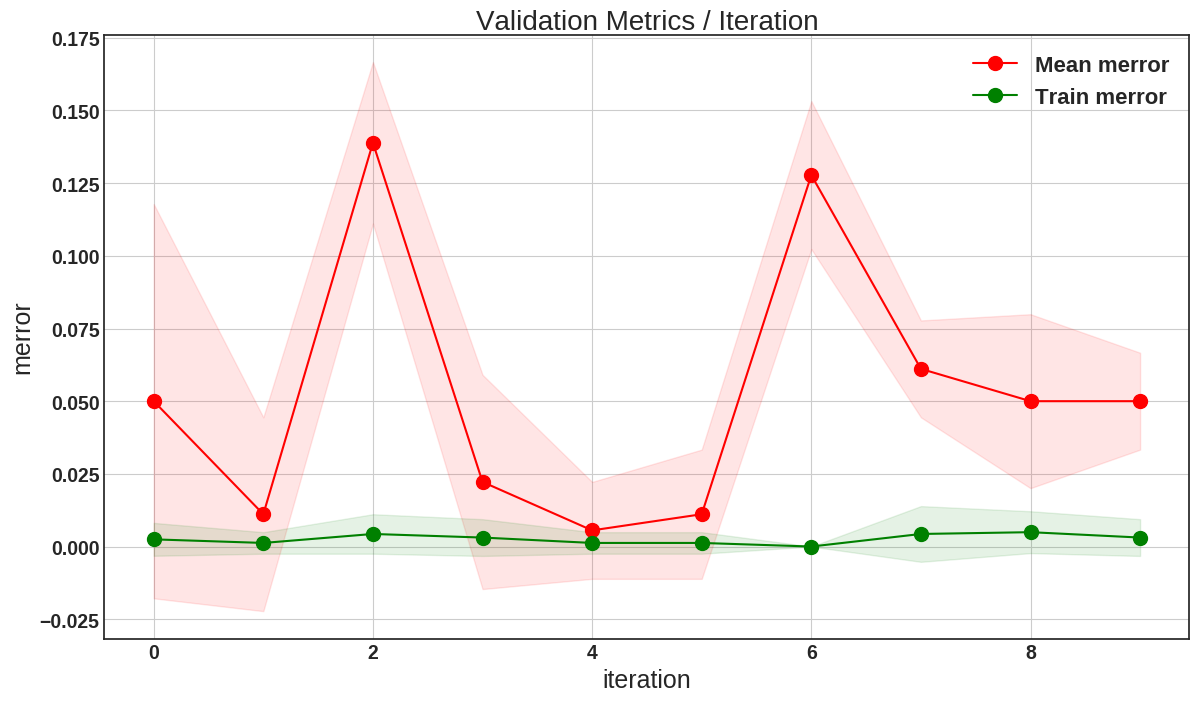

In [35]:
## Set up cross validation
seed = 5
n_splits = 10

## Split df into X and y for fitting 
X,y = df.drop(["activity"], axis = 1),df["activity"]
          
## Compute mean accuracy on test data using CV
accuracy_xgboost, evals = xgb_accuracy_cv(X, y, param, n_splits, seed)

## merror for each iteration on train/test from CV +- 1 std.dev
plot_xgb_iter_metrics(evals)

In [28]:
print(f'The average accuracy of xgboost model from 10 fold cross validation is {np.mean(accuracy_xgboost)}')

The average accuracy of xgboost model from 10 fold cross validation is 0.961111111111111


### Compare performance of xgboost with that of logistic regression and random forest using cross validation

In [29]:
# Build logistic regression and random forest model on this dataset, with 10 fold cross validation 

## prepare models
seed = 5
models = []
models.append(('LR', LogisticRegression()))
models.append(('RF', RandomForestClassifier(random_state = seed)))

## Define X and y
X,y = df.drop(["activity"], axis = 1),df["activity"]

## evaluate each model in turn, with accuracy, sensitivity as well as precision 
accuracy = [np.array(accuracy_xgboost)]
names = ['xgboost']

for name, model in models:
    kfold = model_selection.StratifiedKFold(n_splits=10, random_state=seed)
    accuracy.append(model_selection.cross_val_score(model, X, y, cv=kfold, scoring='accuracy'))
    names.append(name)

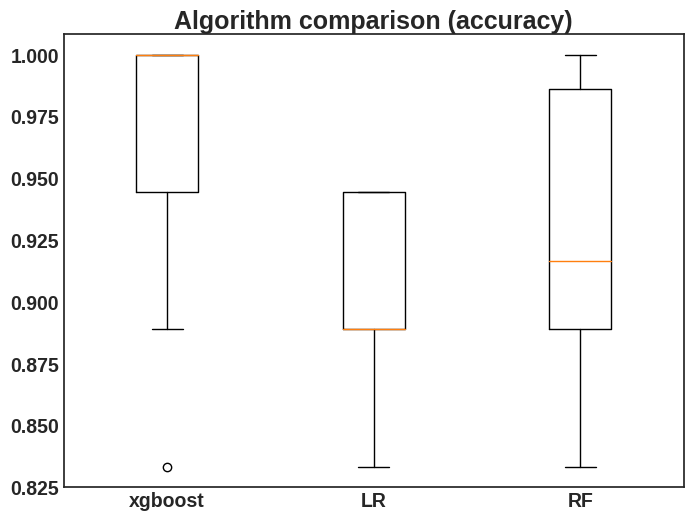

In [30]:
# boxplot accuracy of each algorithm
plt.figure(figsize=(8, 6))
plt.title('Algorithm comparison (accuracy)', fontweight = 'bold', fontsize=18)
plt.boxplot(accuracy)
plt.xticks(np.arange(1,4),names)
plt.show()

<b>Xgboost appears to show slightly better accuracy than logistic regression and random forest for this dataset</b>

<h2>Tuning parameters</h2>

In [31]:
def tune_xgboost(**kw):
    """Compute cross-validated accuracy of XGBoost with updated 
    parameters."""
    bpar = {**param, **kw}
    acc, _ = xgb_accuracy_cv(X, y, bpar, n_splits=10, seed=5,
                             keep_evals=False)
    return np.mean(acc)

## Tune max depth (max depth of trees)
accuracy_tune_maxDepth = []
for max_depth in np.arange(2,11,1):
    accuracy_tune_maxDepth.append(tune_xgboost(max_depth= max_depth))

## Tune eta (learning rate)
accuracy_tune_eta = []
for eta in np.arange(0.1,1,0.1):
    accuracy_tune_eta.append(tune_xgboost(eta = eta))

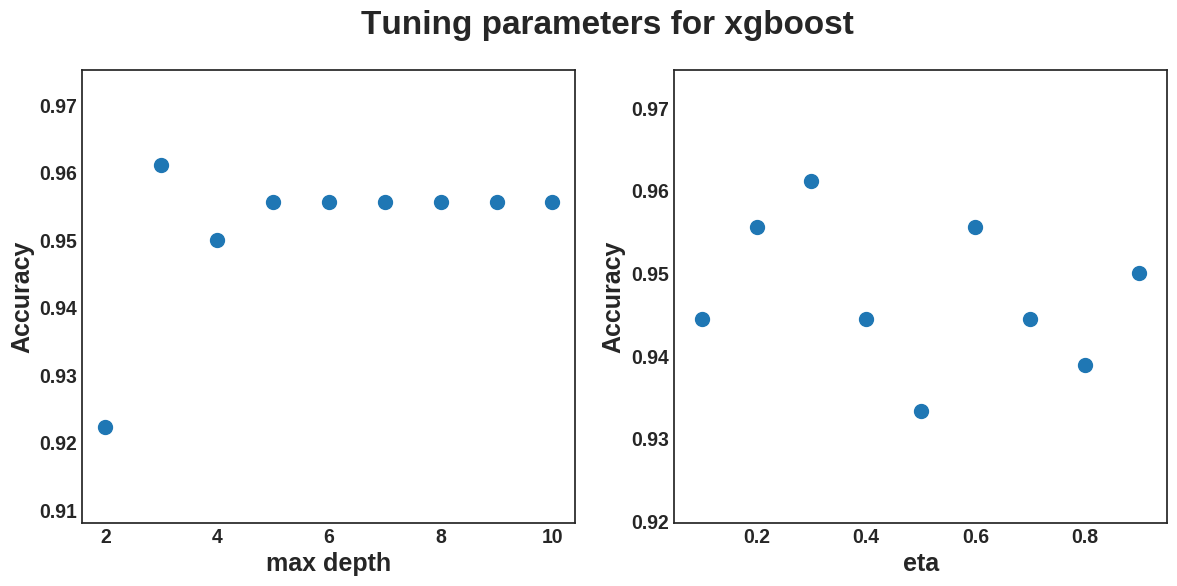

In [32]:
## Plot results
plt.figure(figsize=(14, 6))
plt.suptitle('Tuning parameters for xgboost', fontweight = 'bold', fontsize=24)

plt.subplot(121)
plt.scatter(list(np.arange(2,11)),accuracy_tune_maxDepth)
plt.xlabel("max depth", fontweight = 'bold', fontsize = 18)
plt.ylabel("Accuracy", fontweight = 'bold', fontsize = 18)

plt.subplot(122)
plt.scatter(list(np.arange(0.1,1,0.1)),accuracy_tune_eta)
plt.xlabel("eta", fontweight = 'bold', fontsize = 18)
plt.ylabel("Accuracy", fontweight = 'bold', fontsize = 18)

plt.show()

The xgboost model with `max_depth = 3` and `eta = 0.2 or 0.3` exhibit the best performance 

<h3>ROC curve for xgboost model</h3>

In [33]:
from xgboost import XGBClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import label_binarize

## Binarize labels 
X, y = df.drop(["activity"], axis = 1), df["activity"]
y = label_binarize(y, classes=list(range(6)))
n_classes = 6

## Split into train test sets
X_train, X_test, y_train, y_test =\
    train_test_split(X, y, test_size = 0.3, random_state = 5)

## Train xgboost models using sklearn wrapper
model = OneVsRestClassifier(XGBClassifier(max_depth=3, learning_rate=0.3, 
                                          silent=True, random_state = 5))
## output probabilities for each label 
dt_probas_ = model.fit(X_train.values, y_train).predict_proba(X_test.values)

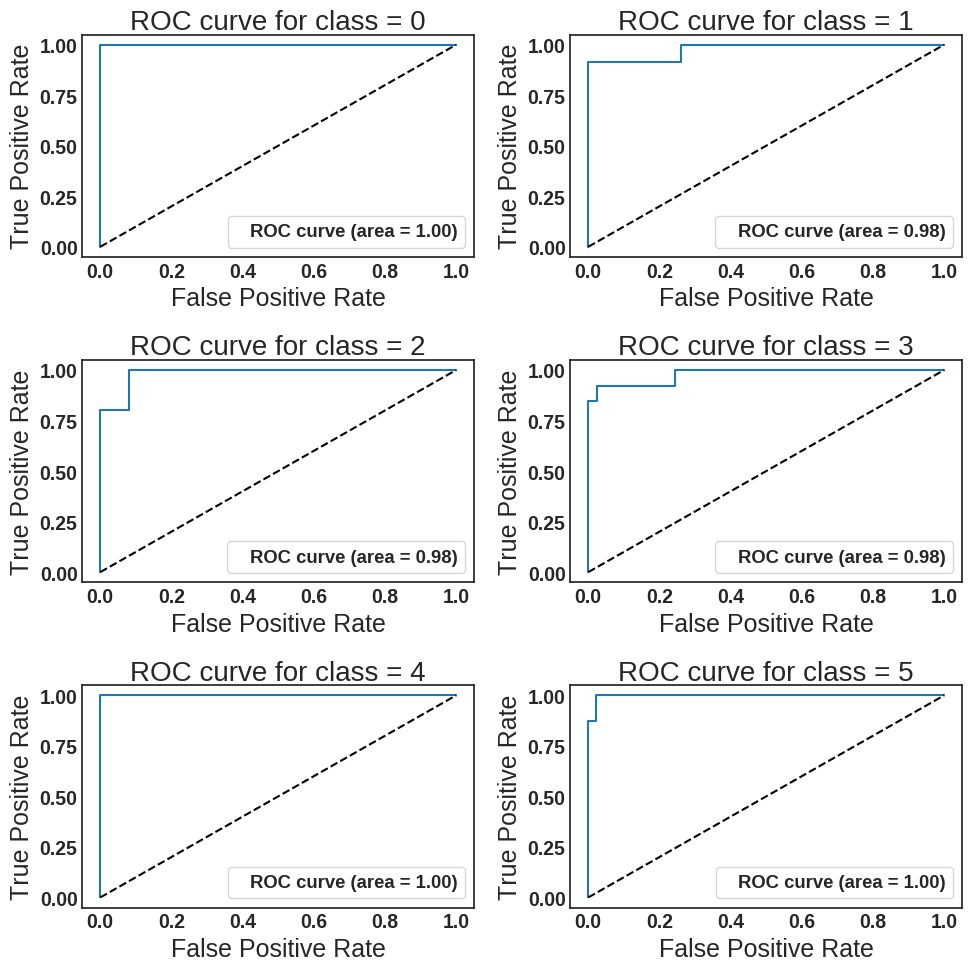

In [34]:
## Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], dt_probas_[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
fig, axes=plt.subplots(figsize=(10,10), nrows=3, ncols=2)

## Plot ROC curves 
n = 0
for i in list(range(3)):
    for j in list(range(2)):
        axes[i][j].plot(fpr[n], tpr[n], label='ROC curve (area = %0.2f)' % roc_auc[n])
        axes[i][j].plot([0, 1], [0, 1], 'k--')
        axes[i][j].set_title(f'ROC curve for class = {n}')
        axes[i][j].set_xlabel('False Positive Rate')
        axes[i][j].set_ylabel('True Positive Rate')
        axes[i][j].set_xlim([-0.05, 1.05])
        axes[i][j].set_ylim([-0.05, 1.05])
        axes[i][j].legend(loc='lower right', fontsize = 'small', frameon = True, handlelength = 0)
        n+=1
        
fig.tight_layout()
plt.show()

